In [1]:
#page0
#input
#train_ImagesPart1_dir : ImagesPart1의 image파일이 있는 directory
#train_ImagesPart2_dir : ImagesPart2의 image파일이 있는 directory
#train_gt_dir : train_gt_t13의 text파일이 있는 directory
#test_img_dir : 2017 validation data의 image파일이 있는 directory
#test_gt_dir : 2017 validation data의 text파일이 있는 directory

train_ImagesPart1_dir = 'ImagesPart1'
train_ImagesPart2_dir = 'ImagesPart2'
train_gt_dir = 'train_gt_t13'
test_img_dir = '2017_validation/img'
test_gt_dir = '2017_validation/txt'

In [3]:
#page1
# making data directories
from make_data import make_batch_idx, save_imgs_to_dir, save_txt_to_dir

# sample data를 train 2000개, validation 200개 data로 나누어 만듦
validation_set,_,_,_,_ = make_batch_idx(train_gt_dir,200)
validation_list = list(validation_set)
validation_list.sort()
save_imgs_to_dir(train_ImagesPart1_dir,train_ImagesPart2_dir,validation_list,'sample_validation/img')
save_txt_to_dir(train_gt_dir,validation_list,'sample_validation/txt')

train_set,_,_,_,_ = make_batch_idx(train_gt_dir,2000,except_list = validation_list)
train_list = list(train_set)
train_list.sort()
save_imgs_to_dir(train_ImagesPart1_dir,train_ImagesPart2_dir,train_list,'sample_train/img')
save_txt_to_dir(train_gt_dir,train_list,'sample_train/txt')

# 10000개의 이미지 중 sample data와 error_gif_idx를 제외하고 test data 941개를 만들고,
                #나머지에서 error_gif_idx=54개를 제외한 9005개를 training data로 만드는 코드
print('making the train, test set directory..')
error_gif_idx=[101, 164, 1437, 1476, 1673, 2645, 2710, 4191, 4195, 4501, 4555, 5040, 5167, 5305, 5453, 5492, 5535, 5644, 5660, 5736, 5770, 5770, 5770, 5778, 5859, 5865, 5878, 5878, 5997, 6109, 6181, 6206, 6408, 6670, 6788, 6803, 6952, 7030, 7061, 7062, 7073, 7173, 7191, 7216, 7216, 7288, 7429, 7504, 7509, 7513, 7566, 7628, 7643, 7947, 8062, 8295, 8295, 8393, 8845]
except_list = validation_list + train_list + error_gif_idx
test_set,_,_,_,_ = make_batch_idx(train_gt_dir,941,except_list = except_list)
test_list = list(test_set)
test_list.sort()
save_imgs_to_dir(train_ImagesPart1_dir,train_ImagesPart2_dir,test_list,'test/img')
save_txt_to_dir(train_gt_dir,test_list,'test/txt')

other_set = set(list(range(10000)))-test_set
other_set = other_set - set(error_gif_idx)
other_idx = list(other_set)
other_idx.sort()
save_imgs_to_dir(train_ImagesPart1_dir,train_ImagesPart2_dir,other_idx,'train/img')
save_txt_to_dir(train_gt_dir,other_idx,'train/txt')
print('done')

making the train, test set directory..
9005
done


In [5]:
#page2
#train 9005개, test 941개, 2017 validation data 1800개에 대한 pkl파일 만들기
import pickle
from data_generate import GTUtility

#train data save as pkl
gt_util = GTUtility(image_path = 'train/img', gt_path = 'train/txt')
file_name = 'ICDAR2019_train.pkl'
print('save to %s...' % file_name)
pickle.dump(gt_util, open(file_name,'wb'))
print('done')

#test data save as pkl
gt_util = GTUtility(image_path = 'test/img', gt_path = 'test/txt')
file_name = 'ICDAR2019_test.pkl'
print('save to %s...' % file_name)
pickle.dump(gt_util, open(file_name,'wb'))
print('done')

#2017 validation data save as pkl
gt_util = GTUtility(image_path = test_img_dir, gt_path = test_gt_dir, val = True)
file_name = 'ICDAR2017_validation.pkl'
print('save to %s...' % file_name)
pickle.dump(gt_util, open(file_name,'wb'))
print('done')

save to ICDAR2019_train.pkl...
done
save to ICDAR2019_test.pkl...
done
save to ICDAR2017_validation.pkl...
done


In [6]:
#page3 
# main training
# ICDAR2019_train.pkl에 저장된 이미지 9005개를 학습
# 1~20 epoch learning rate = 5*e-4
# 21~40 epoch learning rate = 2*e-4

import tensorflow as tf
import numpy as np
import keras
import keras.backend as K
import time
import os
import pickle
from utils.model import load_weights
from data_generate import GTUtility, InputGenerator
from tbpp_model import TBPP512
from default_box import PriorUtil
from focal_loss import TBPPFocalLoss

with open('ICDAR2019_train.pkl', 'rb') as f:
    gt_util_train = pickle.load(f)
    
K.clear_session()
model = TBPP512(softmax=False)
weights_path =None
if weights_path is not None:
    load_weights(model, weights_path)
prior_util = PriorUtil(model)
batch_size = 5
gen_train = InputGenerator(gt_util_train, prior_util, batch_size, model.image_size)
experiment = 'tbpp512fl_synthtext'
epochs = 40
initial_epoch = 0

print('40 epoch training..')
checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

optim = keras.optimizers.Adam(lr=5*1e-4, beta_1=0.9, beta_2=0.999, epsilon=0.001)
loss = TBPPFocalLoss(lambda_conf=1000.0, lambda_offsets=0.1)
model.compile(optimizer=optim, loss=loss.compute)
    
def schedule(x):
    if x < 20:
        lr = 0.0005
    else:
        lr = 0.0002
    return lr
    
history = model.fit_generator(
        gen_train.generate(seed = None),
        steps_per_epoch=int(gen_train.num_batches), 
        epochs=epochs, 
        verbose=1, 
        callbacks=[
                keras.callbacks.ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', verbose=1, save_weights_only=True), 
                keras.callbacks.LearningRateScheduler(schedule, verbose = 1),
                ], 
        class_weight=None,
        initial_epoch=initial_epoch, 
        )


print('done')
print('train done')

Using TensorFlow backend.


40 epoch training..
Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005.
   2/1801 [..............................] - ETA: 10:55:15 - loss: 946.1182 

KeyboardInterrupt: 

Grid searching of confidence threshold by test data
5/5 [==============================] - 6s 1s/step
threshold 0.05 f-measure 0.00
threshold 0.10 f-measure 0.00
threshold 0.15 f-measure 0.00
threshold 0.20 f-measure 0.00
threshold 0.25 f-measure 0.00
threshold 0.30 f-measure 0.00
threshold 0.35 f-measure 0.00
threshold 0.40 f-measure 0.00
threshold 0.45 f-measure 0.00
threshold 0.50 f-measure 0.00
threshold 0.55 f-measure 0.00
threshold 0.60 f-measure 0.00
threshold 0.65 f-measure 0.00
threshold 0.70 f-measure 0.00
threshold 0.75 f-measure 0.00
0.05 0.00437636761487965


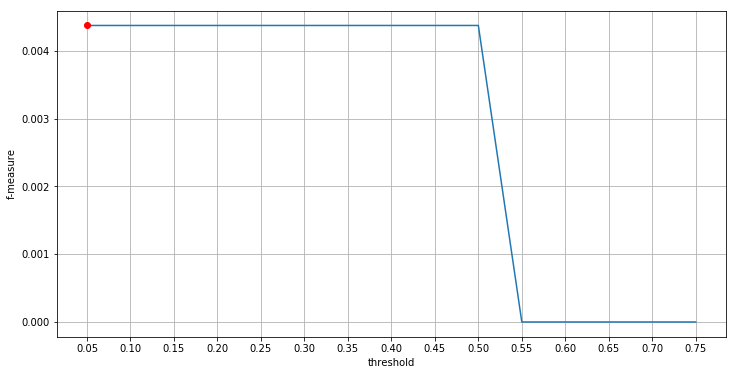

done


In [8]:
#page4
#Grid search
#ICDAR2019_test.pkl에 저장된 test data에서 random하게 이미지 500개를 불러와
    #가장 적절한 confidence threshold를 grid search 방법으로 탐색
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import time
import os
import pickle
from utils.model import load_weights
from tbpp_evaluate import prh
from default_box import PriorUtil
from tbpp_model import TBPP512

print('Grid searching of confidence threshold by test data')
with open('ICDAR2019_test.pkl', 'rb') as f:
    gt_util_test = pickle.load(f)

#model
weights_path = None
if weights_path:
    K.clear_session()
    modelJ = TBPP512(softmax=False)
    load_weights(modelJ, weights_path)
else:
    modelJ = model
    
prior_util = PriorUtil(modelJ)

#Prediction
sample_batch_num = 500
_, inputs, images, data = gt_util_test.sample_random_batch(sample_batch_num, seed = None) 

preds = modelJ.predict(inputs, batch_size=1, verbose=1)

#Grid Search
steps = np.arange(0.05, 0.8, 0.05)
fmes_grid = np.zeros((len(steps)))

for i, t in enumerate(steps):
    results = [prior_util.decode(p, t) for p in preds]
    gt_input = [np.concatenate([g[:,0:8], np.argmax(g[:,8:],axis=1).reshape(-1,1)], axis = 1) for g in data]
    pred_input = [np.concatenate([d[:,4:12], d[:,18].reshape(-1,1)], axis=1) for d in results] 
    precision, recall, fmes = prh(gt_input, pred_input)

    fmes_grid[i] = fmes
    print('threshold %.2f f-measure %.2f' % (t, fmes))
    
max_idx = np.argmax(fmes_grid)
print(steps[max_idx], fmes_grid[max_idx])
plt.figure(figsize=[12,6])
plt.plot(steps, fmes_grid)
plt.plot(steps[max_idx], fmes_grid[max_idx], 'or')
plt.xticks(steps)
plt.grid()
plt.xlabel('threshold')
plt.ylabel('f-measure')
plt.show()
print('done')

In [9]:
#page5
#ICDAR2017_validation.pkl에 저장된 ICDAR 2017 validation data 1800개를 불러와
    #최종 precision, recall, f1 score를 계산

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import time
import os
import pickle
from utils.model import load_weights
from tbpp_evaluate import prh, prh_txt
from default_box import PriorUtil
from tbpp_model import TBPP512

print('f1 score of 2017 validation data')
with open('ICDAR2017_validation.pkl', 'rb') as f:
    gt_util_test = pickle.load(f)

#model
weights_path = None
if weights_path:
    K.clear_session()
    modelJ = TBPP512(softmax=False)
    load_weights(modelJ, weights_path)
else:
    modelJ = model
    
prior_util = PriorUtil(modelJ)

#Prediction
sample_batch_num = 1800 #validation 갯수
_, inputs, images, data = gt_util_test.sample_random_batch(sample_batch_num, seed = None) 

preds = modelJ.predict(inputs, batch_size=1, verbose=1) #수정 한상준10
confidence_threshold = 0.4
results = [prior_util.decode(p, confidence_threshold) for p in preds]
gt_input = [np.concatenate([g[:,0:8], np.argmax(g[:,8:],axis=1).reshape(-1,1)], axis = 1) for g in data]
pred_input = [np.concatenate([d[:,4:12], d[:,18].reshape(-1,1)], axis=1) for d in results] 
prec_total, recall_total, fmes_total = prh(gt_input, pred_input)
prec_txt, recall_txt, fmes_txt = prh_txt(gt_input,pred_input)

print('(text detection + classification) precision, recall, f1 score : ',prec_total, recall_total, fmes_total)
print('(text detection) precision, recall, f1 score : ',prec_txt, recall_txt, fmes_txt)


f1 score of 2017 validation data
   6/1800 [..............................] - ETA: 38:15

KeyboardInterrupt: 